# `multidms` fitting pipeline

Here, we demonstrate the pipeline for fitting a `multidms` model on some data using the tools available in the package. Currently, we show how to pre-process data from various dms experiments targeting Delta and Omicron spike protein homologs.

In [1]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time

# external dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms
%load_ext autoreload
%autoreload 2
%matplotlib inline

**First, we'll define a few global variables.**

**Read in the dms data and list all available experimental conditions**

In [31]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA.1", "Omicron_BA.2"]:
    
    # functional scores
    func_sel = pd.read_csv(f"../results/{homolog}/functional_selections.csv")
    func_sel = func_sel.assign(
        filename = f"../results/{homolog}/" + 
        func_sel.library + "_" + 
        func_sel.preselection_sample + 
        "_vs_" + func_sel.postselection_sample + 
        "_func_scores.csv"
    )
    func_sel = func_sel.assign(
        func_sel_scores_df = func_sel.filename.apply(lambda f: pd.read_csv(f))
    )
    func_sel = func_sel.assign(
        len_func_sel_scores_df = func_sel.func_sel_scores_df.apply(lambda x: len(x))
    )
    fun_sel = func_sel.assign(homolog = homolog)
    func_score_data = pd.concat([func_score_data, fun_sel]).reset_index(drop=True)

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['condition'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}-{row['replicate']}".replace('-Lib',''),
    axis=1
)
func_score_data

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,condition
0,2021-10-28_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1,Lib-1_2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1-1
1,2021-10-28_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2,Lib-1_2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1-2
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3-1
3,2021-10-28_thaw-1_VSVG_control_2,Lib-3,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2,Lib-3_2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3-2
4,2021-10-28_thaw-1_VSVG_control_1,Lib-4,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1,Lib-4_2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4-1
5,2021-10-28_thaw-1_VSVG_control_2,Lib-4,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2,Lib-4_2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4-2
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2-1
7,2021-10-28_thaw-1_VSVG_control_2,Lib-2,thaw-1,2,2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2,Lib-2_2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2-2
8,2022-03-25_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1,Lib-1_2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1-1
9,2022-03-25_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2,Lib-1_2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1-2


**Define all the knobs which define the pipeline's pre-preprocessing behavior**

In [48]:
prep_params = {
    # pre-processing params
    "scale_counts" : False,
    "min_pre_counts" : 100,
    "pseudocount" : 0.1,
    "sample" : False, #5000,
    "min_pre_counts" : 100,
    "clip_target" : (-3.5, 2.5),
    "trim" : False,
    "reference_condition" : "Delta-2-1",
    "conditions" : (
        "Delta-2-1", "Delta-3-1",
        "Omicron_BA.1-2-1", "Omicron_BA.1-3-1",
        "Omicron_BA.2-1-1", "Omicron_BA.2-2-1"
    )
}

In [49]:
# uncomment to reset or if first time running notebook
datasets = pd.DataFrame(columns=list(prep_params.keys()) + ["data"])

## Pre-Proccessing

**Query the conditions to be included in a fit**

In [50]:
func_score_data_sub = func_score_data.query(
    f"condition.isin({prep_params['conditions']})"
)
func_score_data_sub

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,condition
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3-1
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2-1
10,2022-06-22_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2022-06-22_thaw-1_no-antibody_control_1,Lib-2_2022-06-22_thaw-1_VSVG_control_1,Lib-2_2022-06-22_thaw-1_no-antibody_control_1,Lib-2_2022-06-22_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-2_2022-06-22_thaw-...,library pre_samp...,140643,Omicron_BA.1,Omicron_BA.1-2-1
11,2022-06-22_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2022-06-22_thaw-1_no-antibody_control_1,Lib-3_2022-06-22_thaw-1_VSVG_control_1,Lib-3_2022-06-22_thaw-1_no-antibody_control_1,Lib-3_2022-06-22_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-3_2022-06-22_thaw-...,library pre_samp...,125127,Omicron_BA.1,Omicron_BA.1-3-1
12,2022-10-22_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-10-22_thaw-1_no-antibody_control_1,Lib-1_2022-10-22_thaw-1_VSVG_control_1,Lib-1_2022-10-22_thaw-1_no-antibody_control_1,Lib-1_2022-10-22_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.2/Lib-1_2022-10-22_thaw-...,library pre_sampl...,90992,Omicron_BA.2,Omicron_BA.2-1-1
13,2022-10-22_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2022-10-22_thaw-1_no-antibody_control_1,Lib-2_2022-10-22_thaw-1_VSVG_control_1,Lib-2_2022-10-22_thaw-1_no-antibody_control_1,Lib-2_2022-10-22_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.2/Lib-2_2022-10-22_thaw-...,library pre_sampl...,85210,Omicron_BA.2,Omicron_BA.2-2-1


In [51]:
func_score_df = pd.DataFrame()
for idx, row in tqdm(func_score_data_sub.iterrows(), total=len(func_score_data_sub)):
    df = row.func_sel_scores_df.assign(homolog=row.homolog)
    df = df.assign(library = row.library)
    df = df.assign(replicate = row.replicate)
    exp_func_score_df = df.assign(condition=row.condition)
    func_score_df = pd.concat([func_score_df, exp_func_score_df])
func_score_df.rename({"aa_substitutions_reference":"aa_substitutions"}, axis=1, inplace=True)
func_score_df.head()

  0%|          | 0/6 [00:00<?, ?it/s]

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_codon_substitutions,aa_substitutions_sequential,n_aa_substitutions,aa_substitutions,pre_count_threshold,homolog,replicate,condition
0,Lib-3,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,GATTAGAAAACAACCT,-0.8331,0.0015,9697,1688,1154203,358015,0.5,2,K276R L1198F,2,K278R L1200F,20,Delta,1,Delta-3-1
1,Lib-3,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,CAACCGTCACCACCAG,0.1042,0.0010,8201,2734,1154203,358015,0.5,3,T22I R401K E1090D,3,T22I R403K E1092D,20,Delta,1,Delta-3-1
2,Lib-3,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,ACCAAAAGTAGATTCA,0.1985,0.0010,8084,2877,1154203,358015,0.5,2,A1068T,1,A1070T,20,Delta,1,Delta-3-1
3,Lib-3,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,ATCCCACGACATAAAA,-0.3469,0.0015,7226,1762,1154203,358015,0.5,1,D142N,1,D142N,20,Delta,1,Delta-3-1
4,Lib-3,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,GACTAATGACGGGTTC,-0.3512,0.0015,7112,1729,1154203,358015,0.5,0,NaN,0,NaN,20,Delta,1,Delta-3-1


**Optionally subset the variants**

In [52]:
if prep_params["sample"]:
    func_score_df = func_score_df.sample(prep_params["sample"])

**remove all variants with string sites and stop codon wildtypes**

In [53]:
func_score_df.aa_substitutions.fillna("", inplace=True)
gapped_sub_vars = []
stop_wt_vars = []
non_numeric_sites = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
    if "-" in row["aa_substitutions"]:
        gapped_sub_vars.append(idx)
    for sub in row["aa_substitutions"].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)
        if not sub[-2].isnumeric():
            non_numeric_sites.append(idx)

to_drop = set.union(set(gapped_sub_vars), set(stop_wt_vars), set(non_numeric_sites))
func_score_df.drop(to_drop, inplace=True)

  0%|          | 0/521261 [00:00<?, ?it/s]

**Drop all variants with pre-counts below a threshold.**

In [54]:
# Drop barcoded variants with pre-counts below a threshold
n_pre_threshold = len(func_score_df)
func_score_df = func_score_df[func_score_df['pre_count'] >= prep_params["min_pre_counts"]]
print(f"Of {n_pre_threshold} variants, {n_pre_threshold - len(func_score_df)} had fewer than {prep_params['min_pre_counts']} counts before selection, and were filtered out")

Of 438984 variants, 41251 had fewer than 100 counts before selection, and were filtered out


**Optionally, scale the counts**

In [55]:
if prep_params['scale_counts']:
    func_score_df = multidms.utils.scale_func_score(func_score_df)

In [56]:
func_score_df.func_score.describe()

count    397733.000000
mean         -1.431642
std           2.414324
min         -11.483800
25%          -2.002100
50%          -0.629100
75%           0.062600
max           4.048700
Name: func_score, dtype: float64

**Optionally, clip the target functional scores**

In [57]:
if prep_params['clip_target'] and prep_params['trim']:
    l,h = prep_params['clip_target']
    func_score_trim = func_score_df.query(
        f"(func_score >= {l}) & (func_score <= {h})"
    )
    diff = len(func_score_df) - len(func_score_trim)
    print(f"Of {len(func_score_df)} variants, {diff} were thrown during trimming")
    func_score_df = func_score_trim

In [58]:
if prep_params['clip_target'] and not prep_params['trim']:
    func_score_df['func_score'] = func_score_df['func_score'].clip(*prep_params['clip_target'])

## `MultiDmsData`

In [59]:
# uncomment to see docs
# help(multidms.MultiDmsData)
# unscaled_data = data

In [ ]:
data = multidms.MultiDmsData(
    func_score_df,
    alphabet= multidms.AAS_WITHSTOP,
    condition_colors = sns.color_palette("Paired"),
    reference=prep_params['reference_condition']
)

 92%|████████████████████████████████████████████████████████████████████████████▎      | 20218/22001 [00:53<00:04, 380.23it/s]

In [ ]:
data_row = pd.Series(prep_params).to_frame().T
data_row['data'] = data
datasets = pd.concat([datasets, data_row], ignore_index=True)
datasets

In [ ]:
list(datasets["conditions"][0])

In [ ]:
a_data_object = datasets.loc[0, "data"]

In [ ]:
a_data_object.site_map.head()

In [ ]:
a_data_object.mutations[:5]

In [ ]:
a_data_object.mutations_df.head()

In [ ]:
print(a_data_object.variants_df.drop("allowed_variant", axis=1).head()) # TODO, we should probably drop allowed_variant, yes?

In [ ]:
a_data_object.conditions

In [ ]:
a_data_object.reference

In [ ]:
a_data_object.binarymaps # this is poorly named, 'y' also exists here

In [ ]:
a_data_object.non_identical_sites

In [ ]:
a_data_object.non_identical_mutations

**We can run the compiled functions diretly, as well**

In [ ]:

import multidms.model
x = jnp.array(onp.linspace(-10, 10, 100))
custom_params = {"ge_scale":jnp.array([5]) , "ge_bias":jnp.array([50])}
y = multidms.model.softplus_global_epistasis(custom_params, x)
plt.plot(x, y)
plt.show()

In [ ]:
# un-comment to re-initialize results
models = defaultdict(list)

In [ ]:
datasets

In [ ]:
doi = datasets.loc[3, "data"]
bins = onp.arange(-0.5, 10, 1)
doi.plot_times_seen_hist(bins=bins)
doi.plot_func_score_boxplot()

## `MultiDmsModel`

In [ ]:
for dataset in [4]:
    for ge_func in ["sigmoid"]:  
#     for ge_func in ["identity"]:  
        for output_act in ["softplus"]:
            
            imodel = multidms.MultiDmsModel(
                    datasets.loc[dataset, 'data'],
                    latent_model="phi",
                    epistatic_model=ge_func,
                    output_activation=output_act
            )
            
            start = time.time()
            imodel.fit(lasso_shift=3e-5, maxiter=5000)
            end = time.time()
            print(f"{ge_func},{output_act} done. fitting time = {end - start}")
            
            models["ge_func"].append(ge_func)
            models["output_act"].append(output_act)
            models["model"].append(imodel)
            models["dataset"].append(dataset)
            
models_df = pd.DataFrame(models)
models_df.tail(20)

In [195]:
models_df.tail(20)

,ge_func,output_act,model,dataset
0,sigmoid,softplus,<multidms.model.MultiDmsModel object at 0x7f63...,3
1,sigmoid,softplus,<multidms.model.MultiDmsModel object at 0x7f63...,0
2,sigmoid,softplus,<multidms.model.MultiDmsModel object at 0x7f63...,1
3,sigmoid,softplus,<multidms.model.MultiDmsModel object at 0x7f63...,2


ge_func                                                 sigmoid
output_act                                             softplus
model         <multidms.model.MultiDmsModel object at 0x7f63...
dataset                                                       0
Name: 1, dtype: object
Delta-2-1


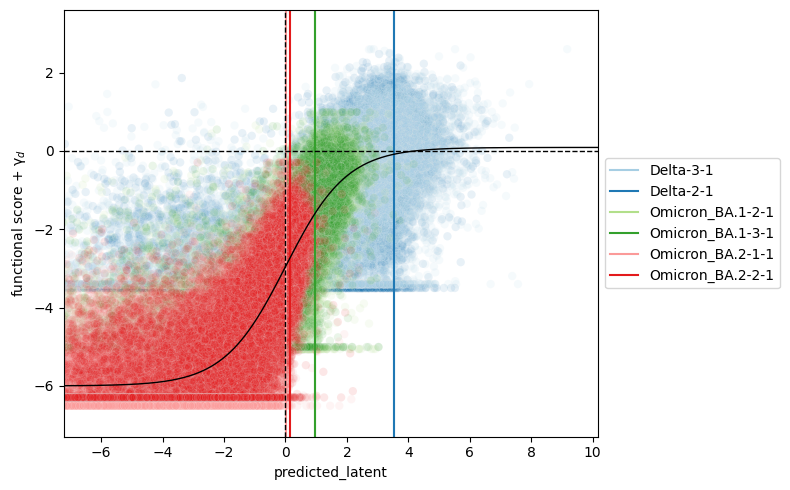

ge_func                                                 sigmoid
output_act                                             softplus
model         <multidms.model.MultiDmsModel object at 0x7f63...
dataset                                                       1
Name: 2, dtype: object
Omicron_BA.1-2-1


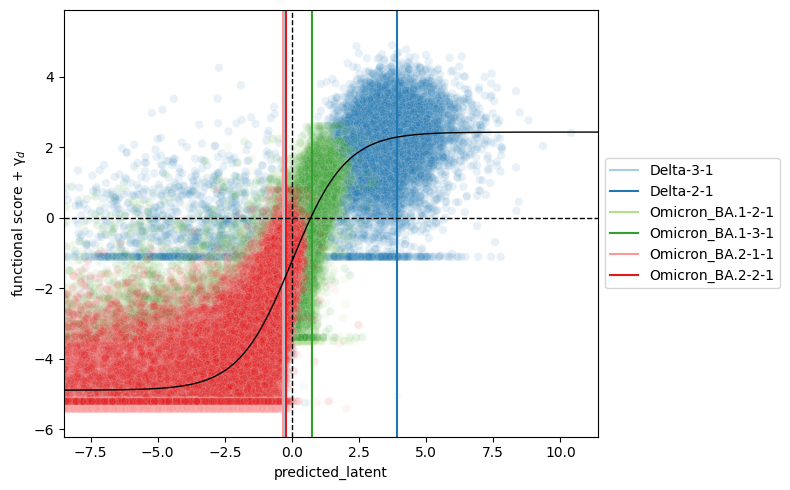

ge_func                                                 sigmoid
output_act                                             softplus
model         <multidms.model.MultiDmsModel object at 0x7f63...
dataset                                                       2
Name: 3, dtype: object
Omicron_BA.2-1-1


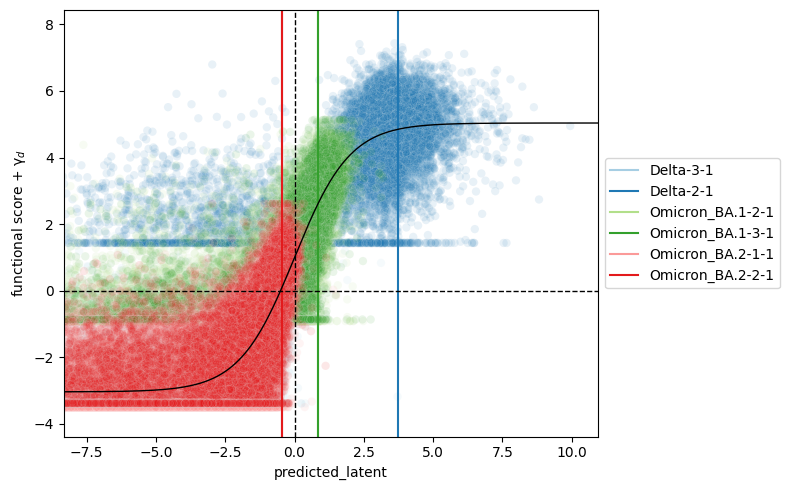

In [196]:
# .loc[57:60, :].iterrows()
for row, values in models_df.loc[1:3, :].iterrows():#.query("dataset == 11").iterrows():

    print(values)
    moi = values.model
    print(moi.data.reference)
#     fig, ax1 = moi.plot_params_by_sites(show=True, figsize=(8, 5))

    # print(moi.sites_df())
#     fig, ax1 = moi.plot_pred_accuracy(show=True, alpha=0.1, figsize=(8, 5))
    fig, ax2 = moi.plot_epistasis(show=False, alpha=0.1, figsize=(8, 5))
    ax2.
#     moi.plot_all_param_hist()


    #     fig, ax = moi.plot_param_hist('S_Omicron_BA.1-2-1', show=False, times_seen_threshold=3)
#     plt.show()
    #     break

    #     fig, ax = moi.plot_param_hist('β', show=True, times_seen_threshold=3)
    #     fig, ax = moi.plot_param_hist('S_Omicron_BA.1-2-1', show=True, times_seen_threshold=3)
    #     fig, ax = moi.plot_param_hist('S_Omicron_BA.2-2-1', show=True, times_seen_threshold=3)
    # .apply(lambda x: sum([abs(t) for t in x if t == t]), axis=0).reset_index()

#     other = models_df.loc[67, "model"]
#     fig, ax = moi.plot_fit_param_comp_scatter(other, site_agg_func=onp.mean)

In [899]:
nim = moi.data.non_identical_mutations['Omicron_BA.1-2-1'].split()
moi.mutations_df.query(f"mutation.isin({nim})")

,mutation,wts,sites,muts,times_seen_Delta-2-1,times_seen_Omicron_BA.1-2-1,β,S_Delta-2-1,F_Delta-2-1,S_Omicron_BA.1-2-1,F_Omicron_BA.1-2-1
189,R19T,R,19,T,38.0,66026.0,0.037532,0.0,0.053774,-0.102626,3.456342
604,A67V,A,67,V,41.0,64878.0,0.070214,0.0,0.086456,0.026678,3.456342
854,T95I,T,95,I,20.0,65741.0,0.392417,0.0,0.408660,-0.209020,3.456342
1339,G156E,G,156,E,1.0,66606.0,0.516691,0.0,0.532933,-0.083347,3.456342
1777,L212I,L,212,I,6.0,65141.0,-0.015594,0.0,0.000648,-0.000000,3.456342
2855,G339D,G,339,D,3.0,65974.0,0.118927,0.0,0.135169,0.047163,3.456342
3090,S371L,S,371,L,0.0,65600.0,0.228604,0.0,0.244846,-0.000486,3.456342
3120,S373P,S,373,P,26.0,66201.0,-0.237820,0.0,-0.221578,0.408925,3.456342
3137,S375F,S,375,F,11.0,65646.0,-0.543888,0.0,-0.527646,-0.321194,3.456342
3453,K417N,K,417,N,23.0,66328.0,-0.770721,0.0,-0.754479,0.724137,3.456342
